In [1]:
import os
import sys
import h5py
import argparse
import numpy as np
from collections import Counter

# 3rd party imports
from sklearn import manifold
from keras.models import Model
from keras import backend as K
from IPython.display import Image

# ML4CVD Imports
from ml4cvd.arguments import parse_args
from ml4cvd.tensor_generators import test_train_valid_tensor_generators
from ml4cvd.recipes import train_shallow_model, train_multimodal_multitask, test_multimodal_multitask
from ml4cvd.models import make_multimodal_to_multilabel_model, train_model_from_generators, make_hidden_layer_model

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '


In [2]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/survey-tensors2/2019-03-25/', 
            '--input_tensors', 'categorical-phenotypes-94', 
            '--output_tensors', 'categorical-phenotypes-94', 
            '--id', 'cat32_mlp',
            '--epochs', '1',
            '--training_steps', '100', 
            '--validation_steps', '2', 
            '--test_steps', '1',             
            '--batch_size', '1024',
            '--model_file', '/mnt/ml4cvd/projects/jamesp/data/models/cat94_autoencoder.hd5'
           ]
args = parse_args()
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,
                                                                                       args.tensor_maps_out,
                                                                                       args.tensors, args.batch_size,
                                                                                       args.valid_ratio,
                                                                                       args.test_ratio,
                                                                                   args.test_modulo,
                                                                                       args.icd_csv,
                                                                                       args.balance_by_icds)
model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)

2019-06-18 20:00:34,505 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/cat32_mlp/log_2019-06-18_20-00_0.log.
2019-06-18 20:00:34,506 - arguments:249 - INFO - Total TensorMaps:1263 Arguments are Namespace(activation='relu', aligned_dimension=16, app_csv='/mnt/disks/data/raw/tsvs/ukb_app17488_app7089_link.csv', b_slice_force=None, balance_by_icds=[], batch_size=1024, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[54, 924, 943, 971, 981, 1011, 1100, 1239, 1249, 1259, 1329, 1339, 1349, 1359, 1369, 1379, 1389, 1408, 1418, 1428, 1448, 1468, 1478, 1508, 1518, 1528, 1538, 1548, 1558, 1618, 1628, 1647, 1677, 1687, 1697, 1707, 1717, 1727, 1747, 1757, 1767, 1777, 1787, 1797, 1835, 2178, 2188, 2207, 2247, 2316, 2306, 2415, 2443, 2453, 2463, 2473, 2674, 2694, 2724, 2784, 2814, 2877, 3079, 3616, 3637, 3773, 37

In [3]:
layer_name = 'dense_1'
d1 = model.get_layer(layer_name)
w1 = d1.get_weights()
rev_cm =  dict((v,k) for k,v in args.tensor_maps_in[0].channel_map.items())
for w in w1:
    print(w.shape)
embed_model = make_hidden_layer_model(model, args.tensor_maps_in, layer_name)
embed_model.summary()
test_data, test_labels, test_paths = next(generate_test)
print(list(test_data.keys()))
x_embed = embed_model.predict(test_data)
y_pred = model.predict(test_data)

(94, 128)
(128,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_categorical-phenotypes (None, 94)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12160     
Total params: 12,160
Trainable params: 12,160
Non-trainable params: 0
_________________________________________________________________
['input_categorical-phenotypes-94_categorical']


In [4]:
categorical_labels = ['Genetic-sex_Female_0_0', 'hypertension', 'coronary_artery_disease', 
                      'Handedness-chiralitylaterality_Righthanded_0_0', 'atrial_fibrillation_or_flutter', 
            'coronary_artery_disease_soft', 'coronary_artery_disease', 'death', 
            'diabetes_type_2', 'heart_failure', 'hypercholesterolemia',
            'hypertension', 'ischemic_stroke', 'myocardial_infarction',  'stroke']
continuous_labels = ['22200_Year-of-birth_0_0|34_Year-of-birth_0_0', '21001_Body-mass-index-BMI_0_0', 
                     '1070_Time-spent-watching-television-TV_0_0', '102_Pulse-rate-automated-reading_0_0', '1488_Tea-intake_0_0', '21002_Weight_0_0']
label_dict = {k: np.zeros((len(test_paths))) for k in categorical_labels + continuous_labels}
to_delete = []
for i, tp in enumerate(test_paths):
    hd5 = h5py.File(tp, 'r')
    #print(list(hd5['continuous'].keys()))
    for k in categorical_labels:
        if k in hd5['categorical']:
            label_dict[k][i] = 1
        elif k in hd5 and hd5[k][0] == 1:
            label_dict[k][i] = 1
    for mk in continuous_labels:
        for k in mk.split('|'):
            if k in hd5['continuous']:
                if hd5['continuous'][k][0] < 0:
                    to_delete.append(i)
                else:
                    label_dict[mk][i] = hd5['continuous'][k][0]
            elif k == mk:
                to_delete.append(i)
                

print(list(label_dict.keys()))
print(x_embed.shape)
print('Will delete:', len(to_delete), 'because they are missing or invalid continuous values.')
for k in label_dict:
    label_dict[k] = np.delete(label_dict[k], to_delete)
x_embed = np.delete(x_embed, to_delete, axis=0)
print(x_embed.shape)

['Genetic-sex_Female_0_0', 'hypertension', 'coronary_artery_disease', 'Handedness-chiralitylaterality_Righthanded_0_0', 'atrial_fibrillation_or_flutter', 'coronary_artery_disease_soft', 'death', 'diabetes_type_2', 'heart_failure', 'hypercholesterolemia', 'ischemic_stroke', 'myocardial_infarction', 'stroke', '22200_Year-of-birth_0_0|34_Year-of-birth_0_0', '21001_Body-mass-index-BMI_0_0', '1070_Time-spent-watching-television-TV_0_0', '102_Pulse-rate-automated-reading_0_0', '1488_Tea-intake_0_0', '21002_Weight_0_0']
(1024, 128)
Will delete: 162 because they are missing or invalid continuous values.
(879, 128)


process key: Genetic-sex_Female_0_0
process key: hypertension
process key: coronary_artery_disease
process key: Handedness-chiralitylaterality_Righthanded_0_0
process key: atrial_fibrillation_or_flutter
process key: coronary_artery_disease_soft
process key: death
process key: diabetes_type_2
process key: heart_failure
process key: hypercholesterolemia
process key: ischemic_stroke
process key: myocardial_infarction
process key: stroke
process key: 22200_Year-of-birth_0_0|34_Year-of-birth_0_0
process key: 21001_Body-mass-index-BMI_0_0
process key: 1070_Time-spent-watching-television-TV_0_0
process key: 102_Pulse-rate-automated-reading_0_0
process key: 1488_Tea-intake_0_0
process key: 21002_Weight_0_0


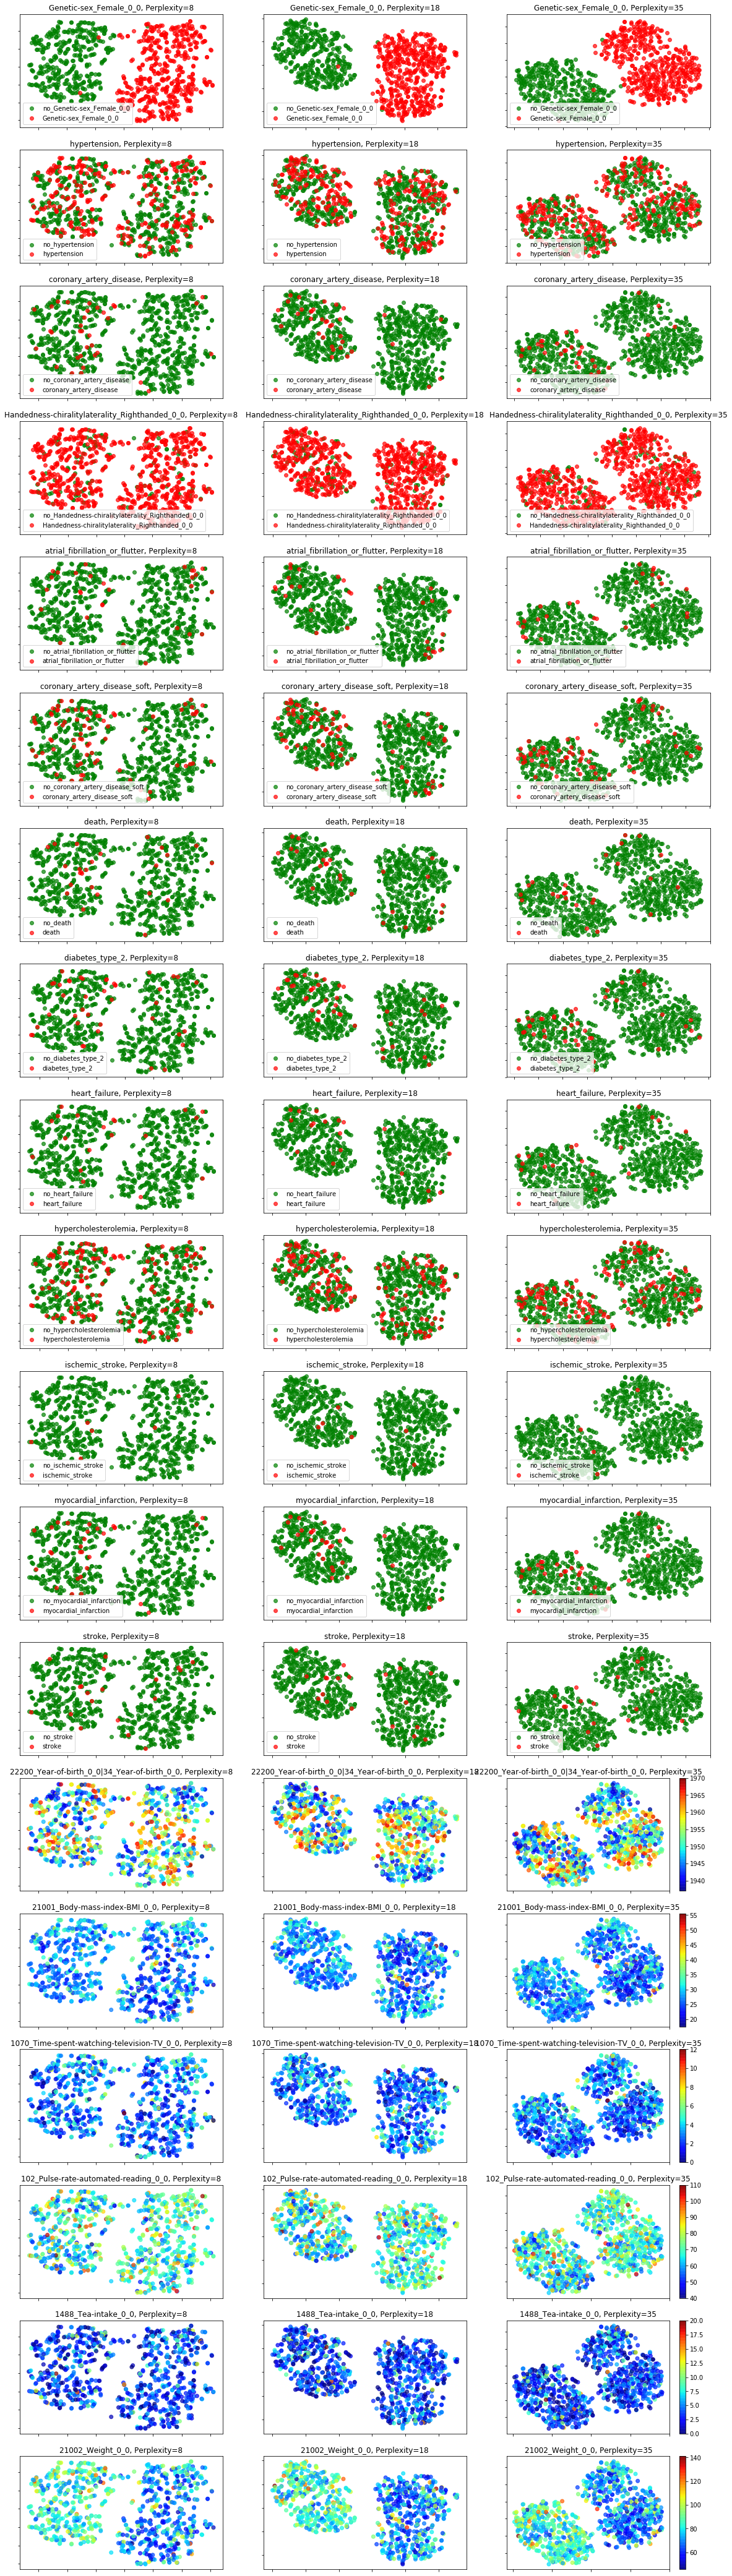

In [5]:
n_components = 2
max_rows = 60
rows = min(max_rows, len(label_dict))
(fig, subplots) = plt.subplots(rows, 3, figsize=(20, rows*4))
perplexities = [8, 18, 35]

p2y = {}
for i, perplexity in enumerate(perplexities):
    tsne = manifold.TSNE(n_components=n_components, init='random', random_state=0, perplexity=perplexity)
    p2y[perplexity] = tsne.fit_transform(x_embed)

j = -1
for k in label_dict:
    j += 1
    if j == max_rows:
        break
    if k in categorical_labels:
        red = label_dict[k] == 1.0
        green = label_dict[k] != 1.0
    elif k in continuous_labels:
        colors = label_dict[k]       
    print('process key:', k)
    for i, perplexity in enumerate(perplexities):
        ax = subplots[j, i]
        ax.set_title(k+", Perplexity=%d" % perplexity)
        if k in categorical_labels:
            ax.scatter(p2y[perplexity][green, 0], p2y[perplexity][green, 1], c="g", alpha=0.7)
            ax.scatter(p2y[perplexity][red, 0], p2y[perplexity][red, 1], c="r", alpha=0.7)
            ax.legend(['no_'+k, k], loc='lower left')
        elif k in continuous_labels:
            points = ax.scatter(p2y[perplexity][:, 0], p2y[perplexity][:, 1], c=colors, cmap='jet', alpha=0.7) 
            if i == len(perplexities)-1:
                fig.colorbar(points, ax=ax)
                
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
plt.show()